In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9012345679012346, Loss: 0.3758039121274595
Checkpoint 200, Accuracy: 0.9444444444444444, Loss: 0.3235944465354637
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.2655239988256384
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.21056931107132523
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.1614975752653899


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [0.05338068 0.9435664  0.00305293]
[1. 0. 0.] <-> [0.9667685  0.03202707 0.0012044 ]
[1. 0. 0.] <-> [0.7995383  0.00668867 0.19377305]
[1. 0. 0.] <-> [0.87924033 0.1121878  0.00857189]
[0. 0. 1.] <-> [0.5619417  0.00296245 0.43509588]
[1. 0. 0.] <-> [0.89510745 0.10262345 0.00226912]
[1. 0. 0.] <-> [0.95951307 0.02623306 0.01425398]
[1. 0. 0.] <-> [0.97896314 0.00571849 0.01531835]
[1. 0. 0.] <-> [0.41523084 0.57543004 0.00933909]
[1. 0. 0.] <-> [0.97740185 0.01148027 0.01111793]
[0. 1. 0.] <-> [0.5962929 0.3865881 0.017119 ]
[1. 0. 0.] <-> [0.94890684 0.00640552 0.04468762]
[1. 0. 0.] <-> [0.96137905 0.00414855 0.0344724 ]
[1. 0. 0.] <-> [0.9716844  0.02134752 0.00696806]
[0. 1. 0.] <-> [0.16680662 0.83001137 0.00318201]
[1. 0. 0.] <-> [0.45960304 0.5393472  0.00104983]
[1. 0. 0.] <-> [0.95982504 0.02665098 0.01352404]
[0. 0. 1.] <-> [8.6465053e-02 3.6318594e-04 9.1317183e-01]
[1. 0. 0.] <-> [0.96701205 0.01184374 0.02114423]
[1. 0. 0.] <-> [0.963543   0.00449961 0.0319

In [12]:
# Testing Performance

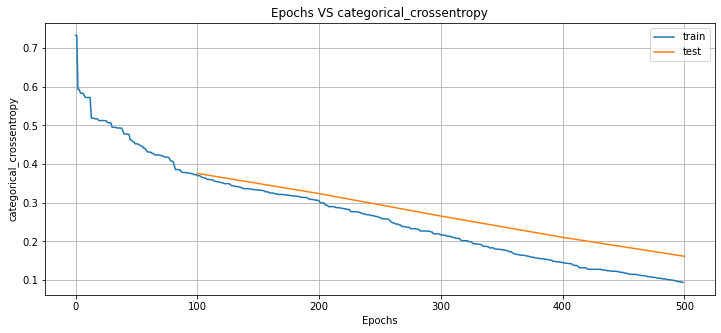

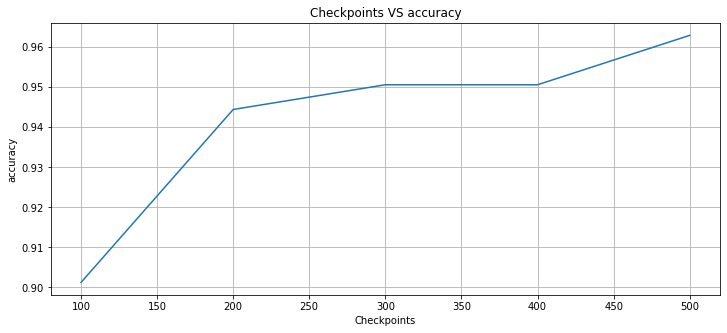

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9012345679012346, 'mean_square_error': 0.21615551436879094, 'categorical_crossentropy': 0.3758039121274595, 'precision': 0.8518518518518519, 'recall': 0.8518518518518519, 'f1': 0.8518518518518519, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 15, 'tn_hit': 15, 'fn_hit': 1}, 1: {'tp_hit': 15, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 14}}, 'checkpoint': 100} 


{'accuracy': 0.9444444444444444, 'mean_square_error': 0.17781886340008835, 'categorical_crossentropy': 0.3235944465354637, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 9, 'tn_hit': 21, 'fn_hit': 0}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 6, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 8}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.13798682457945172, 'categorical_crossentropy': 0.2655239988256384, 'precisio

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 2.0409708 -3.        -2.8500574 -2.2417789  1.0348057]
 bias: 2.7339096069335938

Neuron 1: weights:
[-1.7086077   2.8073263   1.4633783  -1.8074465   0.54844093]
 bias: -0.5523723363876343

Neuron 2: weights:
[1.5265788 1.1937952 1.6702747 2.8104446 2.4516845]
 bias: 2.1868865489959717

Neuron 3: weights:
[ 1.4423921   3.          1.0819732  -3.         -0.85278106]
 bias: 0.8622747659683228

$
Layer 2
Neuron 0: weights:
[ 1.7146446 -1.0113614 -1.9751179  2.7417269]
 bias: 1.488793134689331

Neuron 1: weights:
[-2.994313   2.3713682 -1.6490093  3.       ]
 bias: 0.3986589014530182

Neuron 2: weights:
[-0.38895488 -2.9901192   2.7573252  -2.5331953 ]
 bias: 1.2170453071594238

$

